## Testing the relationship between $\mu$ or $\alpha$ and the amplitudes 

One can think of fitting a model of spheroidal harmonics to a particular spherical mode as fitting to a projection of the overall GW. 

First, we fix a start time that minimises the mismatch. 

Fit $[(2,2,0,1), (3,3,0,1)]$ to $(2,2)$, $[(2,2,0,1), (3,3,0,1)]$ to $(3,3)$ etc. 

We obtain amplitudes $A^{22}_{220+}$, $A^{22}_{330+}$, $A^{33}_{220+}$, $A^{33}_{330+}$ etc.

Then, if we fit a combined model $[(2,2,0,1), (3,3,0,1)]$ to $[(2,2), (3,3)]$, we will obtain different amplitudes $A_{220+}$, $A_{330+}$. 

### Claim: 

$A^{22}_{220+}=\mu_{2220}A_{220+}$, 

$A^{33}_{330+} = \mu_{3330}A_{330+}$ etc. 

Similarly, we should expect this to happen for quadratic modes. This provides a test of the $\alpha$ coefficients. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from qnmfitsrd.qnm import qnm
qnm = qnm()

import qnmfitsrd as qnmfits

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

Mf=sim.Mf
chif=sim.chif_mag

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


#### Choose a start time

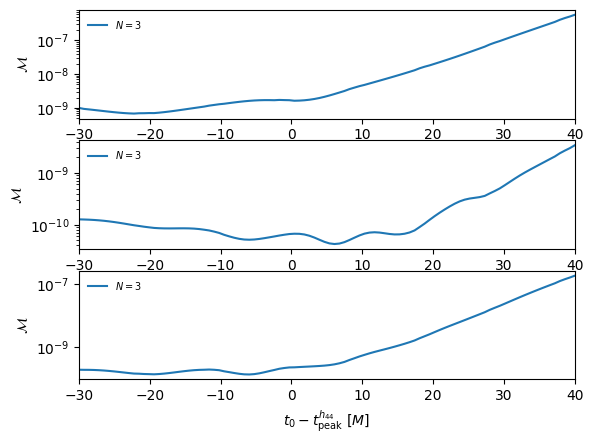

In [14]:
modes = [(l,m,n,1) for l in range(2,9) for m in range (-l,l) for n in range(3+1)]

t0_array = np.linspace(-30, 40, 100)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100)

mm_list_22 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[2,2],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax1.semilogy(t0_array, mm_list_22, label='2,2')
ax1.set_xlim(t0_array[0], t0_array[-1])
ax1.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax1.set_ylabel('$\mathcal{M}$')
ax1.legend(ncol=2, frameon=False, fontsize=7)

mm_list_33 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[3,3],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax2.semilogy(t0_array, mm_list_33, label='3,3')
ax2.set_xlim(t0_array[0], t0_array[-1])
ax2.set_xlabel('$t_0 - t^{h_{33}}_\mathrm{peak}\ [M]$')
ax2.set_ylabel('$\mathcal{M}$')
ax2.legend(ncol=2, frameon=False, fontsize=7)

mm_list_44 = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h[4,4],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array
)

ax3.semilogy(t0_array, mm_list_44, label='4,4')
ax3.set_xlim(t0_array[0], t0_array[-1])
ax3.set_xlabel('$t_0 - t^{h_{44}}_\mathrm{peak}\ [M]$')
ax3.set_ylabel('$\mathcal{M}$')
ax3.legend(ncol=2, frameon=False, fontsize=7)

### Linear case 

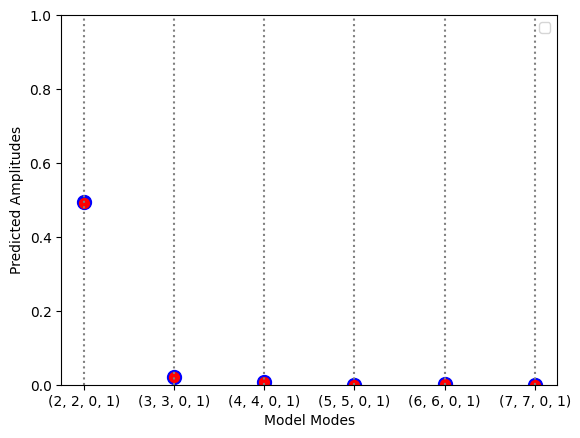

In [145]:
#model_modes = [(l,m,n,1) for l in range(2,8) for m in range(0,l+1) for n in range(0,8)] 
#spherical_modes = list(sim.h.keys())

model_modes = [(2,2,0,1), (3,3,0,1), (4,4,0,1), (5,5,0,1), (6,6,0,1), (7,7,0,1)]
spherical_modes = [(2,2), (3,3), (4,4), (5,5), (6,6), (7,7)]

# Determine the partial amplitudes for each spherical mode 

partial_amplitudes = pd.DataFrame(columns=spherical_modes, index=model_modes) 

for spherical_mode in spherical_modes:
    best_fit = qnmfits.multimode_ringdown_fit(
        sim.times,
        sim.h,
        model_modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0,
        spherical_modes = [spherical_mode]
    )
    partial_amplitudes[spherical_mode] = best_fit['C']

# Determine the full amplitudes for the overall model (with all spherical modes included)

amplitudes = pd.DataFrame(columns=['All'], index=model_modes) 

best_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    model_modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

amplitudes['All'] = abs(best_fit['C'])

# Calculate a matrix of mixing coefficients

indices_lists = [[lm_mode+mode for mode in model_modes] for lm_mode in spherical_modes]
mu_lists = [qnm.mu_list(indices, chif) for indices in indices_lists]
mus = pd.DataFrame(mu_lists, columns=model_modes, index=spherical_modes).T

predicted_amplitudes = abs(partial_amplitudes / mus).T
predicted_amplitudes = predicted_amplitudes.replace([np.inf, -np.inf], np.nan)
predicted_amplitudes_long = predicted_amplitudes.reset_index().melt(id_vars='index', var_name='model_mode', value_name='value')
predicted_amplitudes_long['model_mode'] = predicted_amplitudes_long['model_mode'].astype(str)

plt.scatter(
    x=predicted_amplitudes_long['model_mode'], 
    y=predicted_amplitudes_long['value'],
    s=100,
    color='blue',
)

plt.scatter(
    amplitudes.index.astype(str),
    amplitudes['All'],
    s=50,
    color='red',
)

for x_label in predicted_amplitudes_long['model_mode'].unique():
    plt.axvline(x=x_label, linestyle='dotted', color='gray')

plt.xlabel('Model Modes')
plt.ylabel('Predicted Amplitudes')

plt.ylim(0, 1)
plt.legend()
plt.show()

In [146]:
joined_df = pd.concat([predicted_amplitudes.T, amplitudes], axis=1)
print(joined_df)

                (2, 2)    (3, 3)    (4, 4)    (5, 5)    (6, 6)    (7, 7)  \
(2, 2, 0, 1)  0.494209       NaN       NaN       NaN       NaN       NaN   
(3, 3, 0, 1)       NaN  0.021611       NaN       NaN       NaN       NaN   
(4, 4, 0, 1)       NaN       NaN  0.006856       NaN       NaN       NaN   
(5, 5, 0, 1)       NaN       NaN       NaN  0.000396       NaN       NaN   
(6, 6, 0, 1)       NaN       NaN       NaN       NaN  0.000646       NaN   
(7, 7, 0, 1)       NaN       NaN       NaN       NaN       NaN  0.000173   

                   All  
(2, 2, 0, 1)  0.492520  
(3, 3, 0, 1)  0.021329  
(4, 4, 0, 1)  0.006745  
(5, 5, 0, 1)  0.000378  
(6, 6, 0, 1)  0.000646  
(7, 7, 0, 1)  0.000174  


### Quadratic case

In [167]:
quad_modes = [(2,2,0,1,2,2,0,1), (3,3,0,1,3,3,0,1), (4,4,0,1,4,4,0,1)]
model_modes = [(l,m,n,1) for l in range(2,8) for m in range(0,l+1) for n in range(0,8)]  + quad_modes
#model_modes = [(2,2,0,1), (3,3,0,1), (4,4,0,1)] + quad_modes
spherical_modes = [(2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (8,8)] 

# Determine the partial amplitudes for each spherical mode 

partial_amplitudes = pd.DataFrame(columns=spherical_modes, index=model_modes) 

for spherical_mode in spherical_modes:
    best_fit = qnmfits.multimode_ringdown_fit(
        sim.times,
        sim.h,
        model_modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0,
        spherical_modes = [spherical_mode]
    )
    partial_amplitudes[spherical_mode] = best_fit['C']

# Determine the full amplitudes for the overall model (with all spherical modes included)

amplitudes = pd.DataFrame(columns=['All'], index=model_modes) 

best_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    model_modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

amplitudes['All'] = abs(best_fit['C'])

# Calculate a matrix of mixing coefficients

linear_modes = []
quadratic_modes = []

for mode in model_modes:
    if len(mode) == 4:
        linear_modes.append(mode)
    elif len(mode) == 8:
        quadratic_modes.append(mode)

indices_lists_l = [
    [lm_mode+mode for mode in linear_modes] for lm_mode in spherical_modes]

mu_lists = [qnm.mu_list(indices, chif) for indices in indices_lists_l]

indices_lists_q = [
    [lm_mode+mode for mode in quadratic_modes] for lm_mode in spherical_modes]

alpha_lists = [qnm.alpha(indices, chif) for indices in indices_lists_q]

coef_lists = [mu + alpha for mu, alpha in zip(mu_lists, alpha_lists)]
coef_lists = pd.DataFrame(coef_lists, columns=model_modes, index=spherical_modes).T

predicted_amplitudes = abs(partial_amplitudes / coef_lists).T
predicted_amplitudes = predicted_amplitudes.replace([np.inf, -np.inf], np.nan)
predicted_amplitudes_long = predicted_amplitudes.reset_index().melt(id_vars='index', var_name='model_mode', value_name='value')
predicted_amplitudes_long['model_mode'] = predicted_amplitudes_long['model_mode'].astype(str)

In [168]:
joined_df = pd.concat([predicted_amplitudes.T, amplitudes], axis=1)
print(joined_df)

                                (2, 2)        (3, 3)        (4, 4)  \
(2, 0, 0, 1)                       NaN           NaN           NaN   
(2, 0, 1, 1)                       NaN           NaN           NaN   
(2, 0, 2, 1)                       NaN           NaN           NaN   
(2, 0, 3, 1)                       NaN           NaN           NaN   
(2, 0, 4, 1)                       NaN           NaN           NaN   
(2, 0, 5, 1)                       NaN           NaN           NaN   
(2, 0, 6, 1)                       NaN           NaN           NaN   
(2, 0, 7, 1)                       NaN           NaN           NaN   
(2, 1, 0, 1)                       NaN           NaN           NaN   
(2, 1, 1, 1)                       NaN           NaN           NaN   
(2, 1, 2, 1)                       NaN           NaN           NaN   
(2, 1, 3, 1)                       NaN           NaN           NaN   
(2, 1, 4, 1)                       NaN           NaN           NaN   
(2, 1, 5, 1)        

## Sense Checking

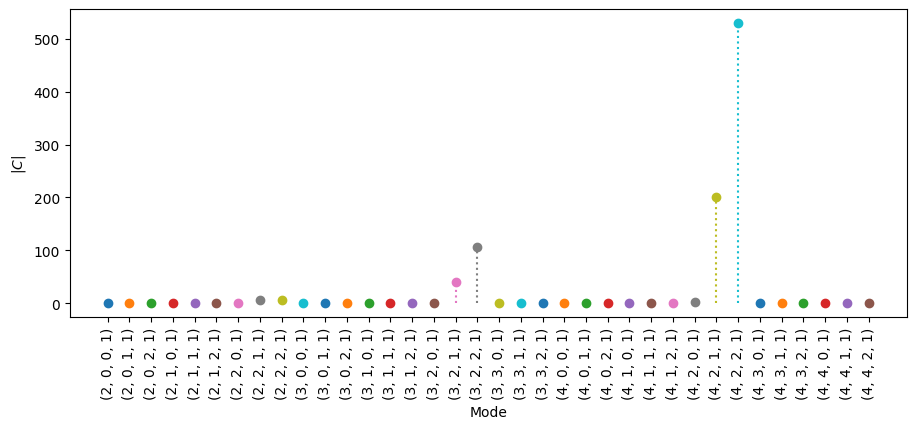

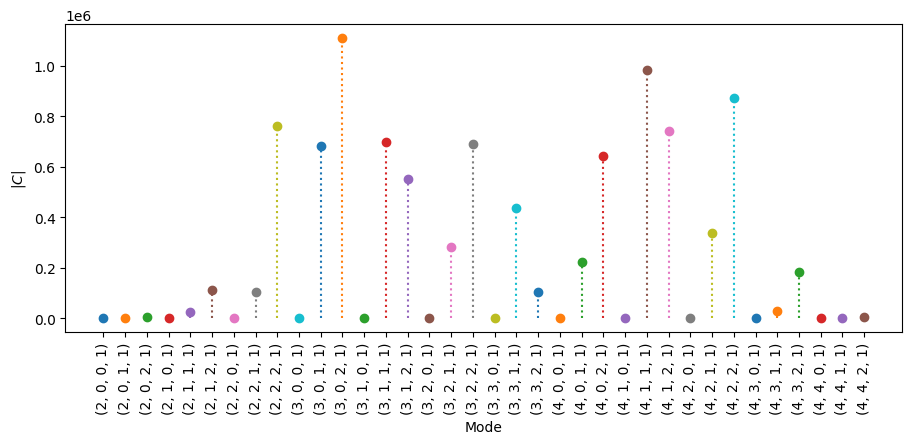

In [95]:
model_modes = [(l,m,n,1) for l in range(2,5) for m in range(0,l+1) for n in range(0,3)] 

best_fit_m = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    model_modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0,
    spherical_modes = [(2,2)]
)

best_fit_s = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    model_modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

qnmfits.plot_mode_amplitudes(
    best_fit_m['C'], best_fit_m['mode_labels'], log=False)

qnmfits.plot_mode_amplitudes(
    best_fit_s['C'], best_fit_s['mode_labels'], log=False)


In [ ]:
amplitudes = [] 

for N in range(3,8):
    model_modes = [(l,m,n,1) for l in range(2,N) for m in range(0,l+1) for n in range(0,N)] 
    print(model_modes)
    best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        model_modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0
    )
    amplitudes.append(abs(best_fit['C'][best_fit['mode_labels'].index('(2, 2, 0, 1)')]))

print(amplitudes)
plt.plot(range(3,8), amplitudes)

plt.xlabel('N')
plt.ylabel('Amplitude of (2,2,0,1) mode')